Thus far, the graphs which have been built to represent conversational dynamics, provide a static structure which lacks the ability to capture the sequential flow of conversation, and consequently its importance in identifying conversational cohesion. To address this shortcoming, we will employ Temporal Graph Neural Networks to represent the flow of conversation. Several TGNNs exist, but they all address a similar task; the interpretation of graph structures that change over time. 

For graphs G1, G2, ..., Gn, a TGNN has the following structure G1 -> G2 -> G3 -> ... -> Gn. Wheras most TGNN tasks focus on node, link, or graph prediciton, we will focus on sequence classification in hopes of defining the cohesion of a meeting based on its progression. We will perform sequence level classification using pytorch geometric pooling methods. 

The static graphs produced until now, cover the paralinguistic aspects of conversation (speaking rate, interruptions, language complexity, etc.). The importance of these features is less dependent on their progression through time. Our temporal analysis will predominantly concern itself with the flow of information in a meeting, as the reception and expression of inforation by each group memeber is largley dependent on the progression of conversation. 

Before delving into the impleentation of graphs, lets first define the assumed conversational scenario, as the preservation of this dynamic throughout analyzed segments is crucial for the developed structures to be founded. Most importantly, all meetings considered must be such that each participant's turn is always: 

    1. The only current turn 
    3. Heard and understood by all participants 

All this said, each meeting segment is represented by a sequence of conversational graphs G such that:
    1. Each Graph, Gn, within the sequence represent the expression of information by one node towards other nodes (one participant turn).
    2. Each Graph, Gn, will have n - 1 directed edges, where n is the number of nodes, all stemming from the node currently speaking towards all other nodes. 
    3. For each Graph Gn, initially only the speaker node will contain an embedding representing their shared information. 
    4. Aside from edges in each Gn, each speaker node will be have a directed edge to its future state such that A1 -> A2 ->...->An

Update and learning structure: Message passing will be applied iterativley to adhere to the flow of conversation and the progress of participant memory. The steps in forward passing will be as follows:

    For each graph G0 ->....-> Gn ->....
        1. Apply one layer of message passing to update the three nodes in Gn that are being spoken to by the speaker node (blue edges). 
        2. Apply one layer of message passing for each node A(n+1) referencing only their previous state An (updated in (1)) 


We will use GAT as an aggregation method in message passing such that:
 1. Different weights are placed on the extent to which a speaker's embedding defines another nodes embedding, as soe participants are more relevant/affected by a speaker's information.  
 2. Different weights are placed on the degree to which a node's past state defines a current state (aka memory) 
 
 Below is an image of the ways graphs will be structured. 

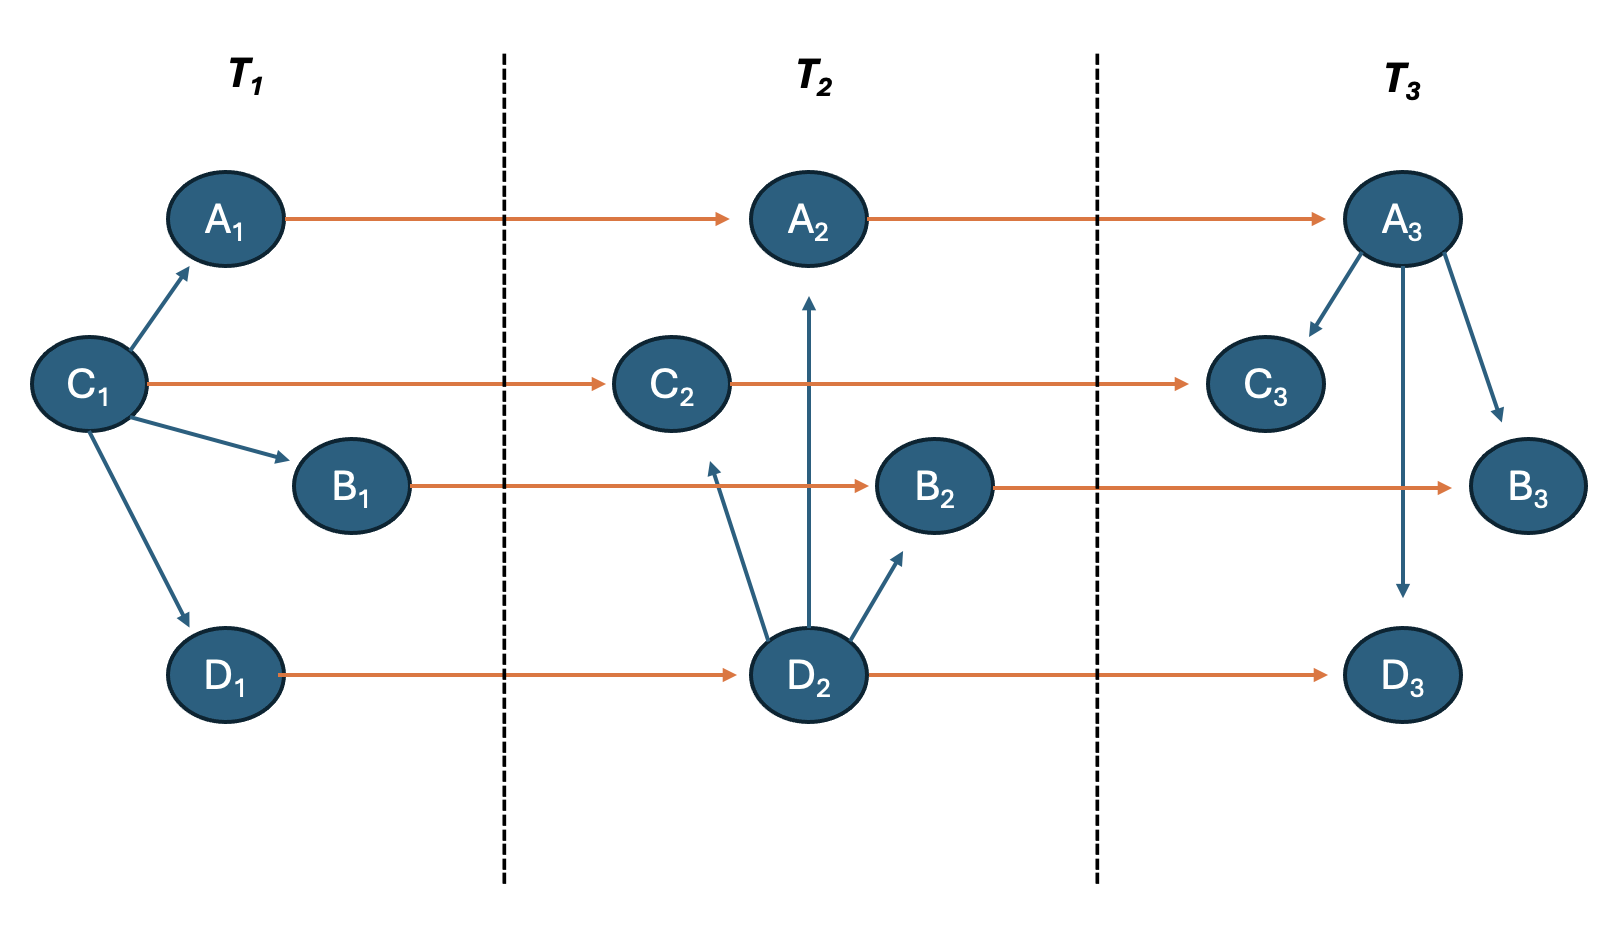

In [1]:
import pandas as pd 
import os

First, we combine all datatframes containing meeting dialogue into one massive data frame and create a function that iterates through each meeting and subsequently through sgment chunks in each meeting of a user specified length. 

In [2]:
base_dir = '../words'  

dialogues = pd.DataFrame()

# Initialize group index
group_index = 0

# Iterate through each folder in the base directory
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    # only for meeting scenarios
    if folder_name[1] == 'S':
        csv_file = f"{folder_name}.csv"
        file_path = os.path.join(folder_path, csv_file)
        df = pd.read_csv(file_path)
        dialogues = pd.concat([dialogues, df], ignore_index=True)
        
dialogues.head()

,Start,End,Speaker,Speech,meeting
0,13.95,14.16,B,Hi .,TS3007a
1,14.71,15.20,C,Hi .,TS3007a
2,15.74,16.25,A,Hello .,TS3007a
3,17.61,17.79,B,Oh .,TS3007a
4,41.74,42.36,A,Good morning .,TS3007a


In [3]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Set the model to evaluation mode to prevent updates to weights
model.eval()

def embedding_func(speech_line):
    """
    Generate BERT embedding for a given speech line.

    Parameters:
    - speech_line: A string representing a single line of speech.

    Returns:
    - A 768-dimensional BERT embedding as a list of floats.
    """
    # Tokenize the input text and convert to PyTorch tensors
    inputs = tokenizer(speech_line, return_tensors='pt', truncation=True, padding=True, max_length=512)

    # Get the model outputs (embedding) from the last hidden layer
    with torch.no_grad():
        outputs = model(**inputs)
    
    # The embeddings are in 'last_hidden_state', take the [CLS] token as the sentence-level embedding
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token embedding
    
    # Convert to a Python list (detaching from the computation graph)
    embedding = cls_embedding.squeeze().tolist()

    return embedding


In [1]:
import pandas as pd

def segment_to_graph(df_unfiltered, char_threshold=5):
    """
    Convert a dataframe representing a segment into a graph stored as a dictionary.

    Parameters:
    - df: Pandas DataFrame with columns ['Start', 'End', 'Speaker', 'Speech', 'meeting'].
    - embedding_func: Function to generate embeddings for each speech line.
    - char_threshold: Minimum length of a speech line to include.

    Returns:
    - Gn: Dictionary representing nodes and edges.
    """

        # Copy the dataframe to avoid modifying the original
    df = df_unfiltered.copy()

    # Filter out rows where the speech line is shorter than the character threshold
    df= df[df['Speech'].str.len() >= char_threshold]
    df.reset_index(drop=True, inplace=True)
    
    # Initialize the dictionary to store nodes and edges
    Gn = {}
    # Create a placeholder for null embeddings (assuming embeddings are vectors)
    null_embedding = [0] * 768  

    # Track the number of total timestamps 
    total_timestamps = len(df)

    # Initialize speaker nodes for each timestamp
    for i in range(total_timestamps):
        # For each speaker (A, B, C, D), create a node with a null embedding
        Gn[f'A_{i}'] = {'embedding': null_embedding, 'edges': []}
        Gn[f'B_{i}'] = {'embedding': null_embedding, 'edges': []}
        Gn[f'C_{i}'] = {'embedding': null_embedding, 'edges': []}
        Gn[f'D_{i}'] = {'embedding': null_embedding, 'edges': []}

        # Create temporal edges (A_n -> A_(n+1)) for each speaker
        if i != total_timestamps - 1:
            Gn[f'A_{i}']['edges'].append(f'A_{i + 1}')
            Gn[f'B_{i}']['edges'].append(f'B_{i + 1}')
            Gn[f'C_{i}']['edges'].append(f'C_{i + 1}')
            Gn[f'D_{i}']['edges'].append(f'D_{i + 1}')

    # Iterate through each row (speech line) of the dataframe
    for i, row in df.iterrows():
        speaker = row['Speaker']
        speech = row['Speech']

        # Generate the embedding for the speech line using the embedding function
        embedding = embedding_func(speech)

        # Assign the generated embedding to the speaker node
        Gn[f'{speaker}_{i}']['embedding'] = embedding

        # Create directed edges from the speaker node to the other nodes
        for node in ['A', 'B', 'C', 'D']:
            if node != speaker:
                Gn[f'{speaker}_{i}']['edges'].append(f'{node}_{i}')

    return Gn



Lets load in the cohesion annotations to know what segments to extract for. 

In [5]:
df_cohesion = pd.read_pickle('../Cohesion_Annotations/Cohesion_split_data.pkl')

Below we create graphs for each annotated segment. 

In [6]:
sub_dfs = []
for index, row in df_cohesion.iterrows():
    # Extract the values from the current row in df_cohesion
    meeting_value = row['Meeting']
    start_time = row['Start'] * 60
    end_time = row['End'] * 60
    kappa = row['Cohesion_Kappa']
    cohesion_score = row['Cohesion_Average'] 

    # Check if the 'Meeting' value is found in the 'meeting' column of the 'dialogues' DataFrame
    if meeting_value in dialogues['meeting'].values:
        # Get the sub-DataFrame where 'meeting' equals the current 'Meeting' and 'Start'/'End' times fall within range
        sub_df = dialogues[(dialogues['meeting'] == meeting_value) & 
                        (dialogues['Start'] >= start_time) & 
                        (dialogues['End'] <= end_time)]
        sub_dfs.append({'df': sub_df, 'meeting': meeting_value, 'start': start_time, 'kappa': kappa, 'cohesion_score': cohesion_score})

Below we create all temporal graphs 

In [7]:
temporal_graphs = []
for df in sub_dfs: 
    G = segment_to_graph(df['df'], char_threshold=10)
    del df['df']
    df['G'] = G
    temporal_graphs.append(df)

In [3]:
temporal_graphs[0]['G']['D_0']

{'embedding': [-0.46728479862213135,
  -0.20498991012573242,
  -0.43848446011543274,
  0.14413221180438995,
  -0.591209352016449,
  -0.104294553399086,
  0.32344233989715576,
  0.25812971591949463,
  0.2573540508747101,
  -0.24465975165367126,
  -0.024298056960105896,
  0.04766726493835449,
  -0.12081604450941086,
  0.347496896982193,
  0.15036003291606903,
  -0.07772357761859894,
  -0.3003997802734375,
  0.33114445209503174,
  0.23793259263038635,
  -0.26681169867515564,
  -0.059008363634347916,
  -0.24291136860847473,
  -0.14477501809597015,
  -0.13205412030220032,
  -0.15546856820583344,
  -0.016052771359682083,
  0.2110808789730072,
  -0.45769003033638,
  -0.04772886633872986,
  0.18121793866157532,
  -0.15621545910835266,
  0.42505887150764465,
  -0.39438194036483765,
  -0.03832992911338806,
  0.07604074478149414,
  -0.1483110785484314,
  0.24063843488693237,
  0.08061264455318451,
  -0.15935151278972626,
  -0.17995861172676086,
  -0.12148511409759521,
  0.07306206971406937,
  0.0

In [9]:
import pickle

# Assuming 'graphs' is your list of graph data
with open('data/temporal_graphs.pkl', 'wb') as f:
    pickle.dump(temporal_graphs, f)